# 0) Подготовка

In [2]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
# import sys
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download ru_core_news_sm
# !{sys.executable} -m pip install gensim==4.3.0
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install WordCloud

In [4]:
import json # обработка json файлов
import pandas as pd # работа с pandas DataFrame
import numpy as np # для работы с числами и последовательностями (финальный вывод)
import matplotlib.pyplot as plt # вывод графиков
import re # регулярные выражения для обработки статей
import string # обработка текста
import spacy # обработка текста + лемматизация слов (приведение к нормальной форме) + создание корпуса
import gensim # для объединения слов в n-граммы
import pyLDAvis.gensim_models # визуализация
import pickle # сохранение
from gensim.corpora import Dictionary # для создания словаря
from gensim.models import LdaModel, LsiModel, Nmf, HdpModel, CoherenceModel # модель + метрика оценивания
from wordcloud import WordCloud
from tqdm import tqdm
from IPython.display import Image # вывод картинки

import warnings # выключение отображение warning-ов
warnings.filterwarnings('ignore')

In [ ]:
def print_coherence(models_arr, param_to_sort, model_name, plot_type="best"): # plot_type - вывод лучшей по параметру (param_to_sort) модели или усреднение
    # param_to_sort: для LDA это 0 - num_topics, 1 - alpha, 2 - beta
    # plot_type: "best", "avg"
    models_by_param = {}
    unique_param_vals = []
    
    for model in models_arr: # считаем уникальные значения выбранного параметра (param_to_sort)
        if model["params"][param_to_sort] not in unique_param_vals:
            unique_param_vals.append(model["params"][param_to_sort])
    unique_vals = len(unique_param_vals) # число уникальных значений
    
    for param in unique_param_vals: # создание словаря по  определённым значениям параметра (param_to_sort)
        models_by_param[param] = []
        for model in models_arr:
            if model["params"][param_to_sort] == param:
                models_by_param[param].append(model)      
    
    cohs = [] # массив когеренций
    if plot_type == "best": # если ищем лучшие, то "закрываем глаза" на другие параметры и ищем лучшиую модель при каждом значении параметра (param_to_sort)
        for param in unique_param_vals:
            best_coh = -9999999
            for model in models_by_param[param]:
                if model["coherence"] > best_coh:
                    best_coh = model["coherence"]
            cohs.append(best_coh)
    elif plot_type == "avg": # иначе - считаем, что другие параметры были значимыми и высчитываем среднее по всем параметрам при фиксированном параметре (param_to_sort)
        for param in unique_param_vals:
            other_params = 0
            avg_coh = 0
            for model in models_by_param[param]:
                other_params+=1
                avg_coh+=model["coherence"]
            cohs.append(avg_coh/other_params)
    else:
        raise Exception(r'param_to_sort should be "best" or "avg"') 

        
    if model_name == "LDA":
        param_to_sort = ["num_topics", "alpha", "beta"][param_to_sort]
    elif model_name == "LSI":
        param_to_sort = ["num_topics", "onepass", "power_iters"][param_to_sort]
    elif model_name == "NMF":
        param_to_sort = ["num_topics", "kappa", 'w_max_iter', 'h_max_iter'][param_to_sort]
    else:
        raise Exception(r'model_name should be "LDA", "LSI" or "NMF"')
    
    plt.figure(figsize=(9, 9))
    plt.title(plot_type)
    plt.plot(unique_param_vals, cohs)
    plt.xlabel(param_to_sort)
    plt.ylabel("Coherence score")
    plt.show()

In [ ]:
def evaluate_bar_graph(coherences, models_names): # функция для вывода bar графика
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    models_names: models_names to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(models_names) # проверка на равное число элементов
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=models_names, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# article_filename = "/content/drive/MyDrive/Универ/articles.json" # путь до файла с полным сохранением статей
article_filename = "articles.json" # путь до файла с полным сохранением статей

In [ ]:
# import gdown
# output = "/content/drive/MyDrive/Универ/articles.json"
# gdown.download(
#     f"https://drive.google.com/uc?export=download&confirm=pbef&id=1d2ItpwJ7JFHa9hPc9XbYBCSpW0nJlt5o",
#     output
# )

# 1) Предобработка данных

In [ ]:
articles = []
with open(article_filename, encoding="utf-8") as file:
    for line in file:
        articles.append(json.loads(line))
data = pd.DataFrame(articles)
data

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...
...,...,...,...,...,...
6114,https://29.ru/text/economics/2018/07/12/65142951/,В Поморье за взятки на два миллиона будут суди...,economics,Экономика,Уголовное дело бывшего госинспектора отдела ав...
6115,https://29.ru/text/economics/2018/07/10/65132941/,В Поморье за год взлетели цены на хлеб и молочку,economics,Экономика,Не успело правительство региона отчитаться о с...
6116,https://29.ru/text/economics/2018/07/05/65115221/,Россельхозбанк запустил вклад «Надежное будущее»,economics,Экономика,АО «Россельхозбанк» предлагает клиентам новый ...
6117,https://29.ru/text/economics/2018/07/04/65112121/,Архангельское УФАС оштрафовало «Архэнергосбыт»...,economics,Экономика,Штраф на ПАО «Архэнергосбыт» наложен постановл...


In [ ]:
nlp = spacy.load("ru_core_news_sm") # nlp (Natural Language Processing) - Объект Language с загруженным pipeline-ом (tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer)

In [ ]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e'])

In [ ]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text) for text in data["text"]] # удаление ссылок
corpus = [text.lower() for text in corpus] # приведение к нижнему регистру
corpus = [re.sub(r'[\d\w-]{1,}\.(ru|com|ua)', ' ', text) for text in corpus] # удаление неполных ссылок
# в статьях нет \n или \t

regex_dig = re.compile('[%s]' % re.escape(string.digits))
corpus = [regex_dig.sub(' ', text) for text in corpus] # убираем цифры

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
corpus = [regex_punct.sub(' ', text) for text in corpus] # убираем пунктуацию

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
corpus = [regex_symb.sub(' ', text) for text in corpus] # убираем дополнительные символы

corpus = [re.sub(' +', ' ', text) for text in corpus] # оставляем максимум 1 пробел
corpus = [text.strip() for text in corpus] # удаляем лишние пробелы в начале и конце статей

In [ ]:
docs = []
for text in corpus:
    docs.append(nlp(text)) # передача данных в pipeline Natural Language Processing

сохранение, так как предыдущий блок очень долго выполнялся

In [ ]:
import pickle
with open(r'nlp_articles.pkl', 'wb') as f: # сохранение в бинарном формате
    pickle.dump(docs, f)

In [ ]:
# with open(r'/content/drive/MyDrive/Универ/nlp_articles.pkl', 'rb') as f:
with open(r'nlp_articles.pkl', 'rb') as f:
    docs = pickle.load(f)
print(docs[0][0].is_stop) # проверка работы

True


In [ ]:
data["text"][0]

'Если бы не было фразеологизмов, наша речь (а возможно, и вся жизнь) была бы куда скучнее. Но еще интереснее не просто пользоваться этими выражениями, но и знать, откуда они произошли и почему мы вообще так стали говорить. Узнать это мы и предлагаем вам прямо сейчас. И не бойтесь ошибиться — это тест не про исключительные знания, а про то, что нас окружает.   '

In [ ]:
docs[0]

если бы не было фразеологизмов наша речь а возможно и вся жизнь была бы куда скучнее но еще интереснее не просто пользоваться этими выражениями но и знать откуда они произошли и почему мы вообще так стали говорить узнать это мы и предлагаем вам прямо сейчас и не бойтесь ошибиться это тест не про исключительные знания а про то что нас окружает

In [ ]:
texts, article, skl_texts = [], [], []
# texts - массив лемматизированных статей (массив из массивов лемм для статей)
# article - массив лемм в одной статье (зануляется при окончании рассматриваемой статьи)
# skl_texts - массив текстов из лемм
for text in docs:
    for idx, w in enumerate(text): # проходимся по всем словам из выбранной статьи
        # если это не стоп-слово и не знак препинания (+ число, конец строки), добавляем его в нашу статью!
#         if not w.is_stop and not w.is_punct and not w.like_num and not w.text in additional_stop_words: # w.text - для взятия слова
        if not w.is_stop and not w.is_punct and not w.like_num and not w.pos_ == "VERB": # w.text - для взятия слова
            # добавляем лематизированную версию слова
            article.append(w.lemma_)
        # если это новая строка, это означает, что мы находимся в нашем следующем документе
        if idx == (len(text) - 1):
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [ ]:
print(texts[0])

['фразеологизм', 'речь', 'жизнь', 'скучный', 'интересный', 'выражение', 'прямо', 'тест', 'исключительный', 'знание']


In [ ]:
print(skl_texts[0])

фразеологизм речь жизнь скучный интересный выражение прямо тест исключительный знание


### Объединение слов в n-граммы

In [ ]:
bigram = gensim.models.Phrases(texts) # обучение модели нахождения n-грамм

In [ ]:
print(texts[-1], "\n\n", bigram[texts[-1]])

['база', 'архангельский', 'филиал', 'россельхозбанк', 'адрес', 'архангельск', 'ул', 'карл', 'либкнехт', 'центр', 'оказание', 'услуга', 'бизнес', 'цоу', 'государственный', 'муниципальный', 'услуга', 'услуга', 'акционерный', 'общество', 'федеральный', 'корпорация', 'развитие', 'малый', 'средний', 'предпринимательство', 'юридический', 'лицо', 'индивидуальный', 'предприниматель', 'гражданин', 'предпринимательский', 'деятельность', 'представитель', 'малый', 'средний', 'предпринимательство', 'доступный', 'окно', 'приём', 'выдача', 'документ', 'цель', 'организация', 'предоставление', 'государственный', 'муниципальный', 'услуга', 'условие', 'соглашение', 'предприниматель', 'город', 'архангельск', 'документ', 'регистрация', 'юридический', 'лицо', 'консультация', 'налог', 'кредитный', 'продукт', 'банк', 'расчётный', 'счёт', 'депозит', 'комплексный', 'поддержка', 'малый', 'средний', 'предпринимательство', 'ценим', 'время', 'клиент', 'насколько', 'важный', 'максимум', 'услуга', 'место', 'появление

In [ ]:
texts_v2 = [bigram[line] for line in texts] # создаём массив лемм для статей с использованием биграммами (во многом он остался схож с обычным texts)

## Вывод самых часто используемых слов в статьях

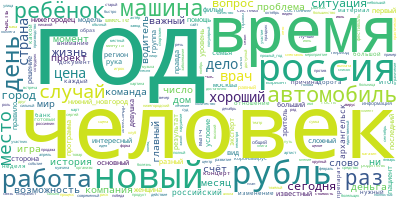

In [ ]:
long_string = ','.join(j for sub in texts_v2 for j in sub) # объединяем все слова

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue') # создание WordCloud объекта

wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
dictionary = Dictionary(texts_v2) # создаём словарь (слова будут в нём не по порядку)

In [ ]:
# print(dictionary[2]) # вывод слова по id
# print(dictionary.token2id["интересный"]) # вывод id, под которым слово записано в словаре

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts_v2] # преобразовывание статей в формат bag-of-words (BoW)

In [ ]:
corpus[0][0:10] # возвращает: (id слова в словаре, сколько раз оно встречается)

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

# 2) Выбор лучшей модели

### Для измерения качества предсказаний тем воспользуемся метрикой "UMass Coherence". Она измеряет частоту появления двух слов вместе в корпусе (считает попарное среднее значение когеренции N слов, описывающих тему). Легко интерпретируема и быстро высчитывается. Чем качественнее модель, тем UMass Coherence --> max (0).

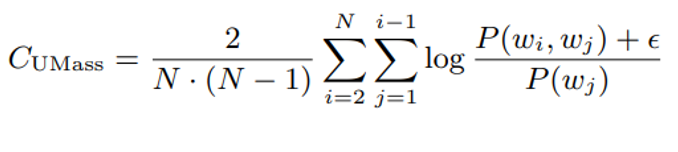

In [ ]:
Image(filename='umass.png') 

## LSI (Latent Semantic Indexing):

In [ ]:
lsi_params={'num_topics': [i for i in range(5, 10)], 
            'onepass': [True, False],  # Whether the one-pass algorithm should be used for training. Pass False to force a multi-pass stochastic algorithm.
            'power_iters': [0,1,2,3,5,10,20]}  # Number of power iteration steps to be used.
lsi_models=[]

for num_topics in tqdm(lsi_params['num_topics']):
    for onepass in lsi_params['onepass']:
        for power_iters in lsi_params['power_iters']:
            # создание LSI модели с передачей корупа corpus, определяемое число тем = num_topics, id2word - ID to word mapping (используем созданный словарь)
            lsimodel = LsiModel(corpus=corpus, 
                              num_topics=num_topics, 
                              id2word=dictionary, 
                              onepass=onepass, 
                              power_iters=power_iters)

            lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
            lsi_coherence = CoherenceModel(topics=lsitopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

            lsi_models.append({'model': lsimodel, 'coherence': lsi_coherence, 'params': [num_topics, onepass, power_iters]})

100%|██████████| 5/5 [17:16<00:00, 207.38s/it]


### Вывод зависимости когеренции от числа тем

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

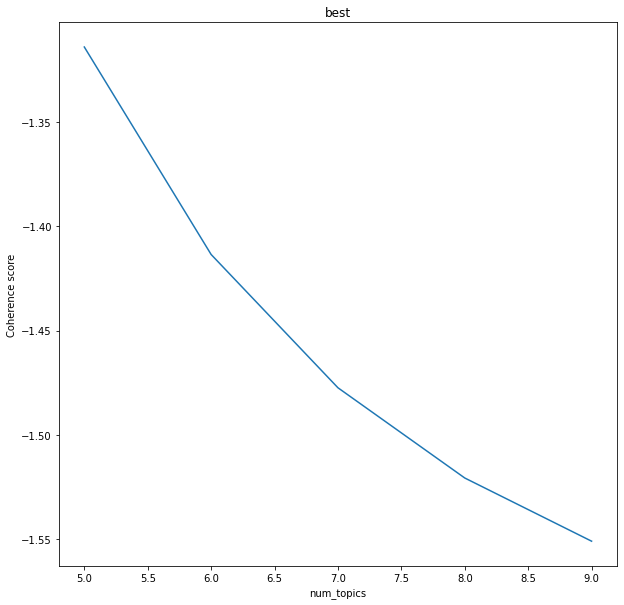

In [ ]:
print_coherence(lsi_models, 0, "LSI", "best")

В LSI модели с увеличением числа тем когерентность ухудшается. 

### Вывод зависимости когеренции от параметра onepass

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

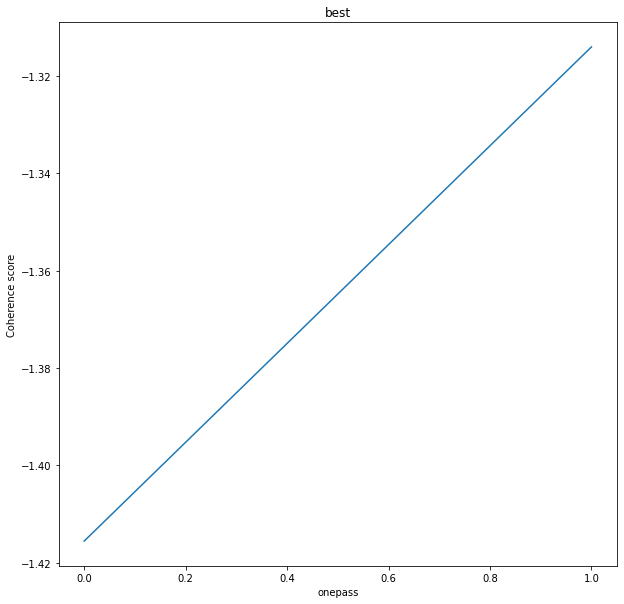

In [ ]:
print_coherence(lsi_models, 1, "LSI", "best")

Алгоритм показал более качественные результаты по метрике когерентности при использовании one-pass алгоритма, в отличие от стохастического multi-pass алгоритма.

### Вывод зависимости когеренции от параметра power_iters

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

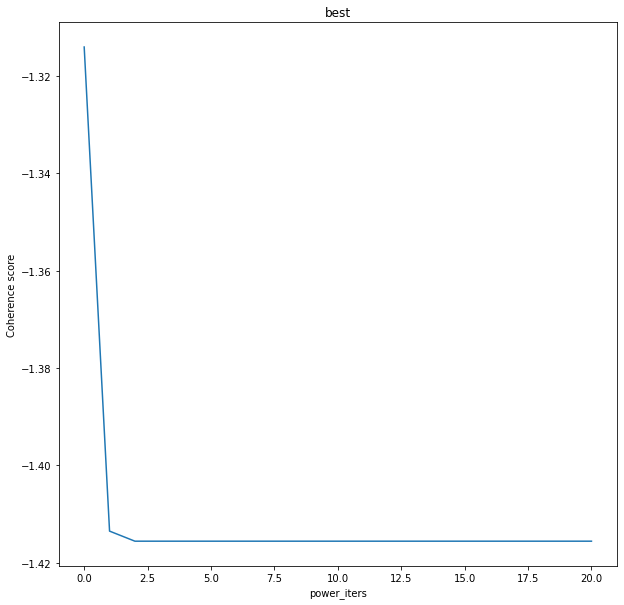

In [ ]:
print_coherence(lsi_models, 2, "LSI", "best")

Увеличение параметра power_iters приводит к ухудшению метрики.

### Вывод лучшей LSI модели

In [ ]:
lsi_models_sorted = sorted(lsi_models, key=lambda d: d['coherence'])

In [ ]:
lsi_models_sorted[-1]['coherence']

-1.327318189051638

In [ ]:
lsi_models_sorted[-1]['model'].show_topics()

[(0,
  '0.605*"год" + 0.281*"человек" + 0.210*"рубль" + 0.159*"россия" + 0.153*"новый" + 0.143*"время" + 0.115*"ребёнок" + 0.110*"автомобиль" + 0.101*"машина" + 0.092*"работа"'),
 (1,
  '0.454*"человек" + -0.415*"рубль" + -0.247*"автомобиль" + -0.181*"год" + -0.171*"цена" + -0.170*"машина" + 0.139*"врач" + 0.106*"жизнь" + 0.103*"работа" + -0.088*"модель"'),
 (2,
  '0.295*"команда" + 0.294*"игра" + 0.279*"матч" + -0.250*"человек" + 0.201*"болельщик" + -0.135*"ребёнок" + 0.126*"стадион" + -0.119*"врач" + 0.114*"город" + 0.114*"счёт"'),
 (3,
  '0.520*"год" + -0.265*"цена" + -0.241*"автомобиль" + -0.211*"машина" + -0.194*"человек" + -0.180*"россия" + -0.082*"случай" + -0.073*"проблема" + -0.073*"российский" + -0.073*"рубль"'),
 (4,
  '-0.344*"рубль" + 0.279*"машина" + -0.278*"ребёнок" + 0.242*"автомобиль" + -0.118*"цена" + 0.108*"новый" + 0.105*"модель" + 0.105*"история" + -0.104*"деньга" + 0.085*"завод"'),
 (5,
  '0.229*"ребёнок" + 0.204*"цена" + 0.201*"рубль" + -0.182*"год" + -0.165*"чел

<pre> Интерпретация выданных тем: 

0) новый год (0.153*"новый" + 0.605*"год")
1) авто
2) спорт
3) авто 
4) авто (~ покупка авто, машина + автомобиль + новый + модель + завод - рубль - деньга)
5) экономика (цена + рубль)
6) авто (~авария, машина + ребенок + водитель + врач - человек - рубль)
</pre>

### Вывод худшей LSI модели

In [ ]:
lsi_models_sorted[0]['coherence']

-1.7989783650768523

In [ ]:
lsi_models_sorted[0]['model'].show_topics()  # Вывод тем для LSI модели

[(0,
  '-0.610*"год" + -0.274*"человек" + -0.210*"рубль" + -0.153*"новый" + -0.149*"россия" + -0.112*"автомобиль" + -0.109*"время" + -0.103*"машина" + -0.102*"цена" + -0.099*"день"'),
 (1,
  '0.396*"рубль" + -0.364*"человек" + 0.231*"цена" + 0.215*"автомобиль" + 0.175*"машина" + 0.164*"год" + -0.155*"врач" + -0.153*"день" + -0.127*"ребёнок" + -0.098*"матч"'),
 (2,
  '-0.325*"человек" + 0.284*"команда" + 0.244*"игра" + 0.244*"год" + 0.229*"матч" + 0.131*"болельщик" + -0.131*"врач" + -0.118*"случай" + 0.111*"нижний_новгород" + -0.101*"машина"'),
 (3,
  '0.451*"год" + -0.200*"автомобиль" + -0.199*"россия" + -0.184*"машина" + 0.179*"ребёнок" + -0.170*"цена" + -0.156*"матч" + -0.149*"рубль" + -0.126*"игра" + -0.122*"команда"'),
 (4,
  '-0.373*"рубль" + 0.286*"автомобиль" + 0.263*"машина" + -0.251*"ребёнок" + -0.168*"врач" + 0.105*"модель" + 0.104*"новый" + 0.104*"человек" + 0.103*"актёр" + -0.100*"регион"'),
 (5,
  '-0.268*"рубль" + 0.231*"год" + -0.190*"город" + 0.149*"врач" + -0.138*"теат

Кроме темы 2 (спорт) и 5 (культура), остальные сложно интерпретируемы.

## NMF (Non-Negative Matrix Factorization):

In [ ]:
nmf_params={'num_topics': [i for i in range(5, 10)], 
            'kappa': [0.1, 0.5, 1.0, 1.5],  # Gradient descent step size
            'w_max_iter': [150, 200, 250],  # Maximum number of iterations to train W per each batch.  W - word-topic matrix
            'h_max_iter': [25, 50, 75]      # Maximum number of iterations to train h per each batch.  h - topic-document matrix
          }
nmf_models=[]

for num_topics in tqdm(nmf_params['num_topics']):
    for kappa in nmf_params['kappa']:
        for w_max_iter in nmf_params['w_max_iter']:
            for h_max_iter in nmf_params['h_max_iter']:
                nmfmodel = Nmf(corpus=corpus, 
                              id2word=dictionary,
                              num_topics=num_topics,
                              w_max_iter=w_max_iter,
                              h_max_iter=h_max_iter) 

                nmftopics = [[word for word, prob in topic] for topicid, topic in nmfmodel.show_topics(formatted=False)]
                nmf_coherence = CoherenceModel(topics=nmftopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

                nmf_models.append({'model': nmfmodel, 'coherence': nmf_coherence, 'params': [num_topics, kappa, w_max_iter, h_max_iter]})

100%|██████████| 5/5 [10:34<00:00, 126.81s/it]


### Вывод зависимости когеренции от числа тем

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

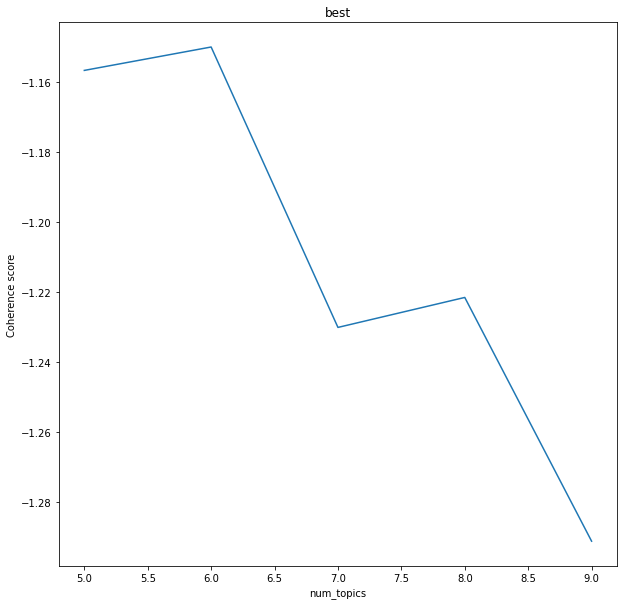

In [ ]:
print_coherence(nmf_models, 0, "NMF", "best")

Как видно на графике, число тем, равное 6 (совпадает с исходным количеством), является лучшим параметром. При использовании num_topics=5 значение метрики когеренции слегка ниже.  При большем же количестве тем coherence score падает.


### Вывод зависимости когеренции от параметра kappa

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

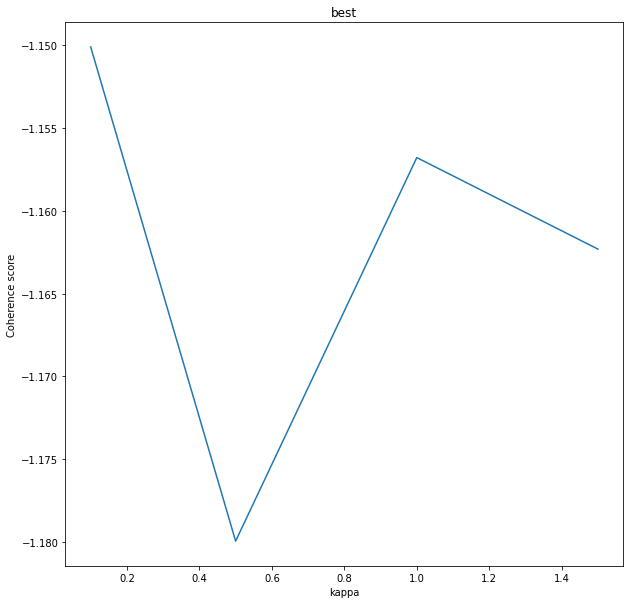

In [ ]:
print_coherence(nmf_models, 1, "NMF", "best")

При уменьшении шага по градиенту kappa, метрика имеет лучшее значение (однако, разница между худшим и лучшим значением метрики составляет всего 0.03), но большие значения этого параметра ускоряют обучение.

### Вывод зависимости когеренции от параметра w_max_iter

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

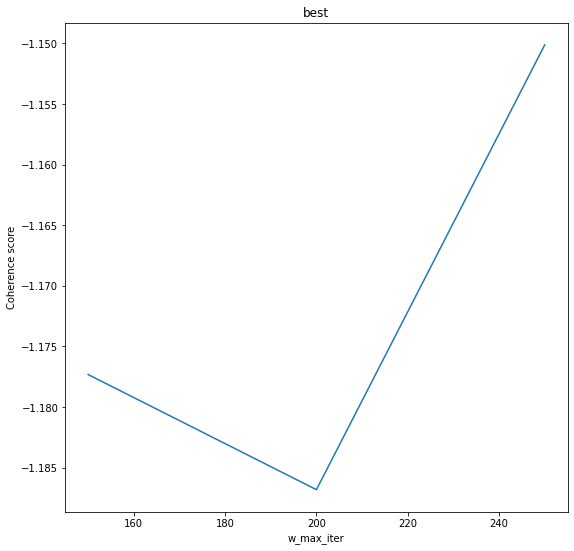

In [ ]:
print_coherence(nmf_models, 2, "NMF", "best")

Худшим значением для данного параметра стало значение по умолчанию (200), а лучшим - 250. 

### Вывод зависимости когеренции от параметра h_max_iter

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

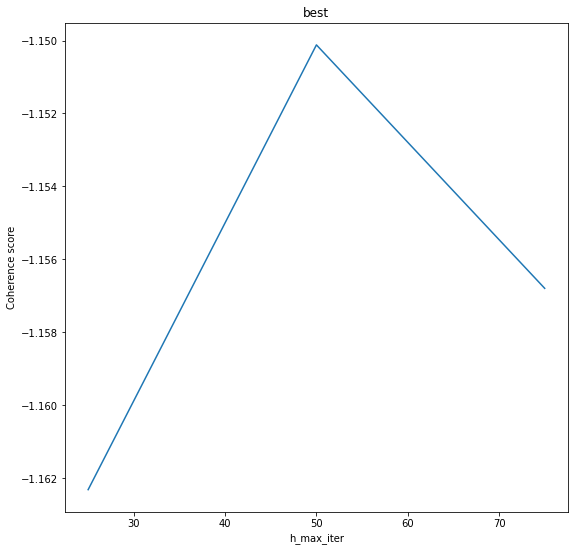

In [ ]:
print_coherence(nmf_models, 3, "NMF", "best")

Лучшим значением для данного параметра оказалось значение по умолчанию (50). 

### Вывод лучшей NMF модели

In [ ]:
nmf_models_sorted = sorted(nmf_models, key=lambda d: d['coherence'])

In [ ]:
nmf_models_sorted[-1]['coherence']

-1.1501185493598707

In [ ]:
nmf_models_sorted[-1]['model'].show_topics()

[(0,
  '0.019*"ребёнок" + 0.014*"новый" + 0.006*"год" + 0.006*"родитель" + 0.005*"время" + 0.005*"работа" + 0.005*"семья" + 0.004*"театр" + 0.004*"жизнь" + 0.004*"день"'),
 (1,
  '0.034*"рубль" + 0.019*"год" + 0.019*"цена" + 0.009*"россия" + 0.006*"новый" + 0.005*"компания" + 0.005*"рынок" + 0.005*"товар" + 0.004*"деньга" + 0.004*"стоимость"'),
 (2,
  '0.009*"игра" + 0.008*"год" + 0.008*"команда" + 0.007*"матч" + 0.007*"нижний_новгород" + 0.006*"хороший" + 0.005*"город" + 0.005*"время" + 0.004*"болельщик" + 0.004*"история"'),
 (3,
  '0.035*"человек" + 0.016*"год" + 0.007*"жизнь" + 0.006*"день" + 0.006*"время" + 0.005*"раз" + 0.004*"дело" + 0.004*"работа" + 0.003*"деньга" + 0.003*"врач"'),
 (4,
  '0.024*"год" + 0.011*"россия" + 0.007*"врач" + 0.006*"случай" + 0.006*"страна" + 0.006*"ситуация" + 0.005*"вопрос" + 0.004*"время" + 0.004*"работа" + 0.004*"проблема"'),
 (5,
  '0.018*"машина" + 0.018*"автомобиль" + 0.010*"водитель" + 0.005*"случай" + 0.004*"модель" + 0.004*"новый" + 0.004*"руб

<pre> Интерпретация выданных тем: 

0) семейный новый год (культура)
1) экономика
2) спорт
3) жизнь
4) проблема
5) авто
</pre>

### Вывод худшей NMF модели

In [ ]:
nmf_models_sorted[0]['coherence']

-1.617823292123256

In [ ]:
nmf_models_sorted[0]['model'].show_topics()  # Вывод тем для NMF модели

[(0,
  '0.025*"рубль" + 0.011*"ребёнок" + 0.010*"месяц" + 0.008*"деньга" + 0.007*"работа" + 0.005*"сумма" + 0.005*"семья" + 0.004*"выплата" + 0.004*"родитель" + 0.004*"жизнь"'),
 (1,
  '0.010*"игра" + 0.010*"команда" + 0.009*"нижний_новгород" + 0.008*"матч" + 0.006*"болельщик" + 0.006*"история" + 0.005*"нижегородец" + 0.005*"место" + 0.005*"город" + 0.004*"нижегородский"'),
 (2,
  '0.088*"год" + 0.008*"новый" + 0.005*"время" + 0.005*"раз" + 0.004*"семья" + 0.004*"работа" + 0.003*"последний" + 0.003*"месяц" + 0.003*"деньга" + 0.003*"александр"'),
 (3,
  '0.021*"машина" + 0.018*"автомобиль" + 0.006*"водитель" + 0.005*"дорога" + 0.004*"город" + 0.004*"новый" + 0.004*"цена_руб" + 0.003*"руль" + 0.003*"двигатель" + 0.003*"концерт"'),
 (4,
  '0.019*"ребёнок" + 0.011*"день" + 0.009*"время" + 0.009*"игра" + 0.008*"команда" + 0.007*"россия" + 0.007*"матч" + 0.006*"новый" + 0.005*"раз" + 0.005*"болельщик"'),
 (5,
  '0.029*"человек" + 0.010*"жизнь" + 0.010*"хороший" + 0.007*"день" + 0.006*"раз" +

<pre> Интерпретация выданных тем: 

0) алименты (экономика)
1) спорт
2) жизнь Александра:)
3) авто 
4) детский спорт
5) исторический фильм (культура)
6) здоровье
7) авто
8) экономика
</pre>

## LDA (Latent Dirichlet Allocation):

### Подбор параметров:

In [ ]:
lda_params = {'num_topics': [i for i in range(5, 10)], 
          'alpha': [*np.arange(0.01, 1, 0.3), 'auto', 'symmetric', 'asymmetric'], 
          'eta': [*np.arange(0.01, 1, 0.3), 'auto', 'symmetric']}

lda_models=[]

for num_topics in tqdm(lda_params['num_topics']):
    for alpha in lda_params['alpha']:
        for eta in lda_params['eta']:
            ldamodel = LdaModel(corpus=corpus, # передаваемый поток документов
                              num_topics=num_topics, # Количество запрошенных скрытых тем, которые необходимо извлечь из учебного корпуса.
                              id2word=dictionary, # Mapping id к словам (словарь)
                              chunksize=2000, # Количество документов, которые будут использоваться в каждом блоке обучения
                              alpha=alpha, # априорное убеждение в распространении тем по документам
                              eta=eta, # априорное убеждение в распределении слов по темам
                              passes=10, # Количество проходов по корпусу во время обучения
                              iterations=200, # Максимальное количество итераций по корпусу при выводе тематического распределения корпуса
                              eval_every=None) # Don't evaluate model perplexity, takes too much time.

            ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
            lda_coherence = CoherenceModel(topics=ldatopics, texts=texts_v2, dictionary=dictionary, window_size=10, coherence="u_mass").get_coherence()

            lda_models.append({'model': ldamodel, 'coherence': lda_coherence, 'params': [num_topics, alpha, eta]})       

In [ ]:
# with open(r'/content/drive/MyDrive/Универ/lda_models.pkl', 'wb') as f:
#     pickle.dump(lda_models, f)

with open(r'lda_models.pkl', 'wb') as f:
    pickle.dump(lda_models, f)

In [2]:
# with open(r'/content/drive/MyDrive/Универ/lda_models.pkl', 'rb') as f:
#     lda_models = pickle.load(f)

with open(r'lda_models.pkl', 'rb') as f:
    lda_models = pickle.load(f)

In [ ]:
# output = "/content/drive/MyDrive/Универ/lda_models.pkl"
# gdown.download(
#     f"https://drive.google.com/uc?export=download&confirm=pbef&id=1bgrJ6iFlogd7a-i79cc8yi-PO8FWUICa",
#     output
# )

### Вывод зависимости когеренции от числа тем

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

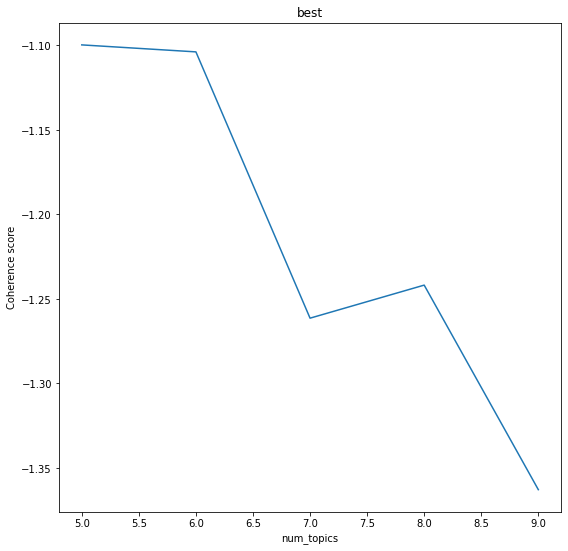

In [ ]:
print_coherence(lda_models, 0, "LDA", "best")

Как видно на графике, наилучшее значение когеренции показывают модели, у которых параметр "количество тем" равен 5 и 6 (схоже с моделью NMF). Это может свидетельствовать о том, что исходное количество категорий было среди этих вариантов (реальное число категорий: 6). При дальнейшем увеличении параметра "количество тем" наблюдается резкое ухудшение метрики когеренции.

### Вывод зависимости когеренции от параметра альфа

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

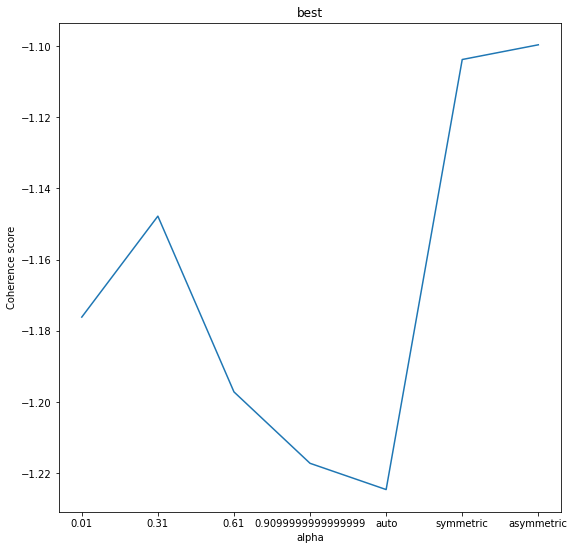

In [ ]:
print_coherence(lda_models, 1, "LDA", "best")

Модели с симметричным и асимметричным распределением тем по документам показывают схожую наилучшую когерентность. Это может исходить из того, что все темы распределены примерно в одинаковом количестве (~1000), следовательно, нет особых причин отдавать предпочтение некоторым темам (выбор symmetric or asymmetric distribution индифферентен). Возможно, более качественное значение альфа лежит в диапазоне от 0.01 до 0.31 (1/6).

### Вывод зависимости когеренции от параметра бета

Лучшее (не обращаем внимание на tuning других параметров, взята лучшая комбинация при фиксированном параметре)

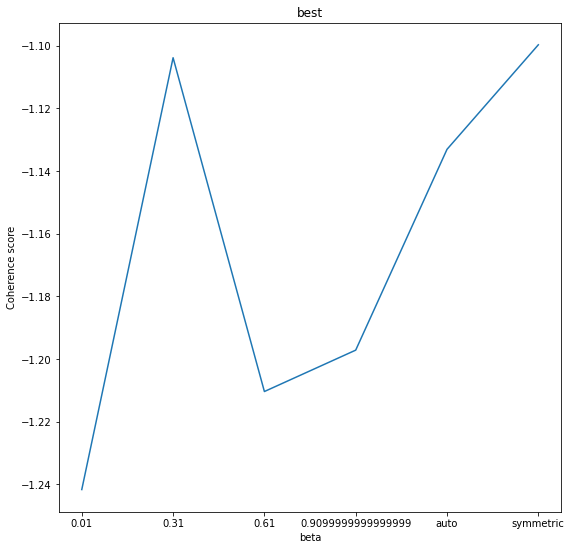

In [ ]:
print_coherence(lda_models, 2, "LDA", "best")

Лучшими вариантами для beta оказались значения 0.31 и symmetric.

### Вывод лучшей LDA модели

In [4]:
lda_models_sorted = sorted(lda_models, key=lambda d: d['coherence'])

In [ ]:
lda_models_sorted[-1]["coherence"]

-1.0996717564822727

In [ ]:
lda_models_sorted[-1]["model"].show_topics()

[(0,
  '0.015*"человек" + 0.011*"год" + 0.006*"ребёнок" + 0.006*"время" + 0.005*"врач" + 0.005*"день" + 0.004*"россия" + 0.004*"раз" + 0.003*"случай" + 0.003*"работа"'),
 (1,
  '0.018*"команда" + 0.017*"игра" + 0.016*"матч" + 0.013*"нижний_новгород" + 0.008*"болельщик" + 0.008*"нижегородец" + 0.007*"счёт" + 0.006*"торпедо" + 0.006*"соперник" + 0.006*"игрок"'),
 (2,
  '0.014*"год" + 0.007*"архангельск" + 0.006*"город" + 0.005*"проект" + 0.005*"фестиваль" + 0.004*"фильм" + 0.004*"новый" + 0.004*"время" + 0.004*"день" + 0.004*"работа"'),
 (3,
  '0.015*"автомобиль" + 0.011*"машина" + 0.010*"год" + 0.008*"рубль" + 0.007*"водитель" + 0.006*"новый" + 0.005*"цена" + 0.005*"россия" + 0.004*"модель" + 0.003*"дорога"'),
 (4,
  '0.025*"год" + 0.017*"рубль" + 0.008*"банк" + 0.006*"россия" + 0.004*"компания" + 0.004*"регион" + 0.004*"деньга" + 0.004*"цена" + 0.004*"страна" + 0.004*"новый"')]

<pre> Интерпретация выданных тем: 

0) здоровье?
1) спорт
2) культура
3) авто 
4) экономика
</pre>

### Вывод худшей LDA модели

In [ ]:
lda_models_sorted[0]["coherence"]

-5.992976427573844

In [ ]:
lda_models_sorted[0]["model"].show_topics()

[(0,
  '0.018*"год" + 0.014*"человек" + 0.009*"ребёнок" + 0.008*"жизнь" + 0.007*"время" + 0.005*"работа" + 0.005*"фильм" + 0.004*"хороший" + 0.004*"пациент" + 0.004*"новый"'),
 (1,
  '0.013*"автомобиль" + 0.011*"машина" + 0.008*"кроссовер" + 0.008*"двигатель" + 0.007*"модель" + 0.006*"квитанция" + 0.006*"версия" + 0.006*"новый" + 0.005*"мотор" + 0.005*"салон"'),
 (2,
  '0.009*"рубль_килограмм" + 0.007*"экономический_форум" + 0.006*"шина" + 0.003*"резина" + 0.003*"право_собственность" + 0.002*"шиномонтаж" + 0.001*"зимний_резина" + 0.001*"экономика_регион" + 0.001*"coca_cola" + 0.001*"бурлак"'),
 (3,
  '0.030*"год" + 0.017*"рубль" + 0.010*"банк" + 0.005*"регион" + 0.005*"работа" + 0.005*"деньга" + 0.004*"вклад" + 0.004*"россия" + 0.004*"средство" + 0.004*"компания"'),
 (4,
  '0.017*"человек" + 0.012*"врач" + 0.009*"случай" + 0.006*"коронавирус" + 0.006*"водитель" + 0.006*"день" + 0.005*"препарат" + 0.004*"заболевание" + 0.004*"ребёнок" + 0.004*"ситуация"'),
 (5,
  '0.018*"монета" + 0.008

<pre> Интерпретация выданных тем: 

0) развлечения?
1) авто
2) экономика + авто + резина
3) экономика
4) здоровье
5) экономика (денежный подарок)
6) культура + экономика
7) спорт
8) авто (покупка)
</pre>

### Тематическая согласованность (Topic Coherence)
Чем выше значение когерентности, тем лучше модель

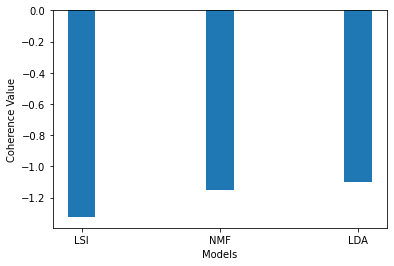

In [ ]:
evaluate_bar_graph([lsi_models_sorted[-1]["coherence"], nmf_models_sorted[-1]["coherence"], lda_models_sorted[-1]["coherence"]],
                   ['LSI', 'NMF', 'LDA'])

Самой лучшей моделью оказалась LDA со значением U-Mass когеренции=-1.09, поэтому дальнейший анализ будем проводить для неё.

In [5]:
# Сохраним лучшую модель
# with open(r'/content/drive/MyDrive/Универ/best_lda_model.pkl', 'wb') as f:
with open(r'best_lda_model.pkl', 'wb') as f:
    pickle.dump(lda_models_sorted[-1]['model'], f)

Наглядное представление подобранных LDA моделью тем (если не отображается, см. файл lda_best_visual.html)

In [ ]:
pyLDAvis.enable_notebook()
visualisation = pyLDAvis.gensim_models.prepare(lda_models_sorted[-1]["model"], corpus, dictionary)
# pyLDAvis.save_html(visualisation, '/content/drive/MyDrive/Универ/lda_best_visual.html')
pyLDAvis.save_html(visualisation, 'lda_best_visual.html')
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.069984 -0.037967       1        1  35.985814
2      0.027789 -0.219593       2        1  21.708091
3     -0.030046  0.061186       3        1  18.352150
4     -0.218688  0.101737       4        1  16.505654
1      0.290930  0.094636       5        1   7.448292, topic_info=               Term          Freq         Total Category  logprob  loglift
183           рубль   5793.000000   5793.000000  Default  30.0000  30.0000
2230     автомобиль   3624.000000   3624.000000  Default  29.0000  29.0000
328         команда   2252.000000   2252.000000  Default  28.0000  28.0000
57              год  17315.000000  17315.000000  Default  27.0000  27.0000
3899           игра   2082.000000   2082.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1842         тренер    299.072286    449.432194   Topic5  -5.7987   2.1899
641          россия    439.762053   5455.643808   Topic5  -5.4132   0.0790
515         сегодня    346.482958   1991.102405   Topic5  -5.6516   0.8486
2019          гость    290.824570   1000.135585   Topic5  -5.8267   1.3620
2435  нижегородский    279.952231    787.525885   Topic5  -5.8648   1.5629

[371 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
32881      3  0.993593               bmw
15597      1  0.997064             covid
15597      3  0.002191             covid
33665      3  0.993147            duster
32889      3  0.990253       lada_granta
...      ...       ...               ...
4321       4  0.992914         экономист
8221       3  0.992650     электромобиль
241        4  0.995122  юридический_лицо
3011       2  0.986332           ярмарка
3011       4  0.010203           ярмарка

[721 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 5, 2])

Проведем анализ зависимости топикообразующих слов у выбранной модели с реальными категориями, представленными в рассмотренном корпусе.

Скачиваем модель векторизации для русского языка.

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/220.zip

In [212]:
!unzip /content/220.zip  -d /content/220/

Archive:  /content/182.zip
  inflating: /content/182/meta.json  
  inflating: /content/182/model.bin  
  inflating: /content/182/model.txt  
  inflating: /content/182/README     


In [57]:
model = gensim.models.KeyedVectors.load_word2vec_format('220/model.bin', unicode_errors='ignore', binary=True)

In [ ]:
# Приведем слова в модели в соответствующий вид
for i, word in enumerate(model.index_to_key):
  model.index_to_key[i] = re.sub('_[A-Z]+', '', word)

new_dict = {}
for word in model.key_to_index.keys():
  new_key = re.sub('_[A-Z]+', '', word)
  if new_key not in new_dict.keys():
    new_dict[new_key] = model.key_to_index[word]

model.key_to_index = new_dict
model.key_to_index

In [28]:
# Топикообразующие слова
topics = [["человек", "год", "ребенок", "время", "врач", "день", "россия", "раз", "случай", "работа"], 
 ["команда", "игра", "матч",  "болельщик", "нижегородец", "счет", "торпедо", "соперник", "игрок"], 
 ["год", "архангельск", "город", "проект", "фестиваль", "фильм", "новый", "время", "день", "работа"],
 ["автомобиль", "машина", "год", "рубль", "водитель", "новый", "цена", "россия", "модель", "дорога"], 
 ["год", "рубль", "банк", "россия", "компания", "регион", "деньга", "цена", "страна", "новый"]]

In [29]:
# Считаем частоту слов 
freq = {}
for topic in topics:
  for word in topic:
    if word not in freq.keys():
      freq[word] = 1
    else:
      freq[word] += 1
freq

{'человек': 1,
 'год': 4,
 'ребенок': 1,
 'время': 2,
 'врач': 1,
 'день': 2,
 'россия': 3,
 'раз': 1,
 'случай': 1,
 'работа': 2,
 'команда': 1,
 'игра': 1,
 'матч': 1,
 'болельщик': 1,
 'нижегородец': 1,
 'счет': 1,
 'торпедо': 1,
 'соперник': 1,
 'игрок': 1,
 'архангельск': 1,
 'город': 1,
 'проект': 1,
 'фестиваль': 1,
 'фильм': 1,
 'новый': 3,
 'автомобиль': 1,
 'машина': 1,
 'рубль': 2,
 'водитель': 1,
 'цена': 2,
 'модель': 1,
 'дорога': 1,
 'банк': 1,
 'компания': 1,
 'регион': 1,
 'деньга': 1,
 'страна': 1}

In [68]:
# Удалим одинаковые слова, встречающиеся в разных топиках
for i, topic in enumerate(topics):
  topics[i] = [word for word in topic if freq[word] == 1]

In [31]:
topics

[['человек', 'ребенок', 'врач', 'раз', 'случай'],
 ['команда',
  'игра',
  'матч',
  'болельщик',
  'нижегородец',
  'счет',
  'торпедо',
  'соперник',
  'игрок'],
 ['архангельск', 'город', 'проект', 'фестиваль', 'фильм'],
 ['автомобиль', 'машина', 'водитель', 'модель', 'дорога'],
 ['банк', 'компания', 'регион', 'деньга', 'страна']]

In [61]:
real_categories = ['экономика', "здоровье", "культура", "авто", "спорт", "развлечение"]

Определяем соответствие сгенерированных LDA моделью тем (топикообразующих слов) реальным категориям. Категории указаны в порядке уменьшения косинусного сходства. 

In [71]:
for i, topic in enumerate(topics):
  print('Topic: ', i, topic)
  similarity = {}
  for real_topic in real_categories:
    top1 = model.most_similar(positive=topic, topn=1)[0][0]
    similarity[real_topic] = model.similarity(top1, real_topic)
  sim_sorted = sorted(similarity.items(), key=lambda item: item[1], reverse=True)
  
  for sim in sim_sorted:
    print(sim)
  print('\n')

Topic:  0 ['человек', 'ребенок', 'врач', 'раз', 'случай']
('здоровье', 0.38151672)
('экономика', 0.09284188)
('авто', 0.042927776)
('развлечение', 0.04153846)
('культура', -0.0139930295)
('спорт', -0.046587262)


Topic:  1 ['команда', 'игра', 'матч', 'болельщик', 'нижегородец', 'счет', 'торпедо', 'соперник', 'игрок']
('спорт', 0.097401425)
('авто', 0.06149914)
('здоровье', -0.02480824)
('экономика', -0.025446303)
('развлечение', -0.122622214)
('культура', -0.16136682)


Topic:  2 ['архангельск', 'город', 'проект', 'фестиваль', 'фильм']
('развлечение', 0.18186103)
('культура', 0.15515433)
('спорт', 0.15455759)
('авто', 0.015112481)
('экономика', -0.09790391)
('здоровье', -0.14805982)


Topic:  3 ['автомобиль', 'машина', 'водитель', 'модель', 'дорога']
('авто', 0.60903656)
('развлечение', 0.063565224)
('экономика', -0.072412625)
('здоровье', -0.07729703)
('спорт', -0.0823197)
('культура', -0.2216502)


Topic:  4 ['банк', 'компания', 'регион', 'деньга', 'страна']
('экономика', 0.3421615)


Соответствие сгенерированных LDA моделью тем (топикообразующих слов) реальным категориям получилось достаточно точным, несмотря на наличие тем, где подобрать соответствующую категорию нелегко (из-за присутствия слов, которые можно отнести к разным темам, например, культура и развлечения). Так, к примеру, слова из топика 0 хорошо соответствуют теме здоровье, что была представлена в исходном корпусе, из топика 1 - спорту, из топика 2 слова можно определить как к теме развлечение, так и к культуре, что и произошло, так как косинусная мера между этими темами не столь различна. В 3м топике почти все слова можно однозначно отнести к теме авто, поэтому мера схожести довольно велика. Слова же из последнего топика явно коррелируют с темой экономики, что и отразила модель.
